In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [16]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 256
LR = 0.001
DOWNLOAD_MNIST = False

In [17]:
path = 'content/drive/MyDrive/Colab Notebooks/'
if not(os.path.exists(os.path.join(path,'./mnist/'))) or not os.listdir(os.path.join(path,'./mnist/')):    
    DOWNLOAD_MNIST = True


# Transform
transform = transforms.Compose(
                [transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),]
                )

training_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True, # train parameter=True means getting trainingdata, False for testing data
    transform=transform,
    download=DOWNLOAD_MNIST
)

train_loader = DataLoader(dataset=training_data, batch_size=BATCH_SIZE, shuffle=True)

In [47]:
valid_data = torchvision.datasets.MNIST(root='./mnist/', train=False, transform=transform)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE, shuffle=False)

In [62]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1   = nn.Conv2d(in_channels = 1,out_channels = 6,kernel_size = 5,stride=1,padding=2)    
    self.conv2   = nn.Conv2d(in_channels = 6,out_channels = 16,kernel_size = 5,stride=1,padding=2)
    # self.conv3   = nn.Conv2d(in_channels = 6,out_channels = 16,kernel_size = 5,stride=1,padding=2)
    self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1     = nn.Linear(in_features=16*7*7, out_features=120)
    self.fc2     = nn.Linear(in_features=120, out_features=84)
    self.fc3     = nn.Linear(in_features=84, out_features=10)  

  def forward(self, x):
    # print(x.shape)
    x = self.conv1(x)
    # print(x.shape)
    x = self.pooling(x)
    # print(x.shape)
    x = self.conv2(x)
    # print(x.shape)
    x = self.pooling(x)
    # print(x.shape)
    # x = x.view(-1, 16*5*5)
    # print(x.shape)
    x = torch.flatten(x,1)
    # print(x.shape)
    x = self.fc1(x)
    # print(x.shape)
    x = self.fc2(x)
    # print(x.shape)
    x = self.fc3(x)
    # print(x.shape)

    return x

In [63]:
model = LeNet()
print(model)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [85]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    total_train = 0
    correct_train = 0
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target) 
        
        # if CUDA:
        #     data, target = data.cuda(), target.cuda()

        # clear gradient
        optimizer.zero_grad()

        # Forward propagation
        output = model(data) 
        loss = criterion(output, target) 

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        total_train += len(target)
        correct_train += sum((predicted == target).float())
        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Train Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, EPOCH, batch_idx+1, len(train_loader),
               correct_train / float((batch_idx + 1) * BATCH_SIZE),
               train_loss / float((batch_idx + 1) * BATCH_SIZE)))
            
    train_acc_ = 100 * (correct_train / float(total_train))
    train_loss_ = train_loss / total_train
                    
    return train_acc_, train_loss_

In [86]:
def validate(valid_loader, model, criterion, epoch): 
    model.eval()
    total_valid = 0
    correct_valid = 0
    valid_loss = 0
    
    for batch_idx, (data, target) in enumerate(valid_loader):
        data, target = Variable(data), Variable(target) 
        
        # if CUDA:
        #     data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target) 

        predicted = torch.max(output.data, 1)[1]
        total_valid += len(target)
        correct_valid += sum((predicted == target).float())
        valid_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Valid Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, EPOCH, batch_idx+1, len(valid_loader),
               correct_valid / float((batch_idx + 1) * BATCH_SIZE),
               valid_loss / float((batch_idx + 1) * BATCH_SIZE)))
            
    valid_acc_ = 100 * (correct_valid / float(total_valid))
    valid_loss_ = valid_loss / total_valid
                    
    return valid_acc_, valid_loss_

In [87]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader):
    # set objects for storing metrics
    total_train_loss = []
    total_valid_loss = []
    total_train_accuracy = []
    total_valid_accuracy = []
 
    # Train model
    for epoch in range(EPOCH):
        # training
        train_acc_, train_loss_ = train(train_loader, model, criterion, optimizer, epoch)
        total_train_loss.append(train_loss_)
        total_train_accuracy.append(train_acc_)

        # validation
        with torch.no_grad():
            valid_acc_, valid_loss_ = validate(valid_loader, model, criterion, epoch)
            total_valid_loss.append(valid_loss_)
            total_valid_accuracy.append(valid_acc_)

        print('==========================================================================')
        print("Epoch: {}/{}， Train acc： {:.6f}， Train loss： {:.6f}， Valid acc： {:.6f}， Valid loss： {:.6f}".format(
               epoch+1, EPOCH, 
               train_acc_, train_loss_,
               valid_acc_, valid_loss_))
        print('==========================================================================')

    print("====== END ==========")

    return total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy

In [88]:
def plot_result(total_train, total_valid, label):
    plt.plot(range(EPOCH), total_train, 'b-', label=f'Training_{label}')
    plt.plot(range(EPOCH), total_valid, 'g-', label=f'validation_{label}')
    plt.title(f'Training & Validation {label}')
    plt.xlabel('Number of epochs')
    plt.ylabel(f'{label}')
    plt.legend()
    plt.show()

Train Epoch: 1/10 [iter： 1/235], acc： 0.441406, loss： 0.008376
Train Epoch: 1/10 [iter： 101/235], acc： 0.851679, loss： 0.002045
Train Epoch: 1/10 [iter： 201/235], acc： 0.898574, loss： 0.001379
Valid Epoch: 1/10 [iter： 1/40], acc： 0.984375, loss： 0.000329
Epoch: 1/10， Train acc： 90.688339， Train loss： 0.001266， Valid acc： 96.650002， Valid loss： 0.000434
Train Epoch: 2/10 [iter： 1/235], acc： 0.953125, loss： 0.000854
Train Epoch: 2/10 [iter： 101/235], acc： 0.963026, loss： 0.000464
Train Epoch: 2/10 [iter： 201/235], acc： 0.965660, loss： 0.000438
Valid Epoch: 2/10 [iter： 1/40], acc： 0.988281, loss： 0.000190
Epoch: 2/10， Train acc： 96.680000， Train loss： 0.000430， Valid acc： 97.489998， Valid loss： 0.000315
Train Epoch: 3/10 [iter： 1/235], acc： 0.984375, loss： 0.000279
Train Epoch: 3/10 [iter： 101/235], acc： 0.975015, loss： 0.000324
Train Epoch: 3/10 [iter： 201/235], acc： 0.976252, loss： 0.000308
Valid Epoch: 3/10 [iter： 1/40], acc： 0.992188, loss： 0.000179
Epoch: 3/10， Train acc： 97.611664， 

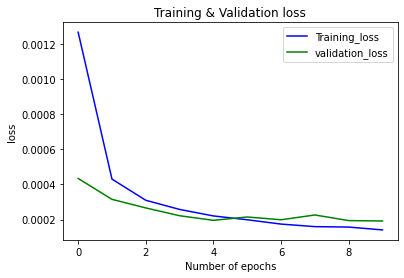

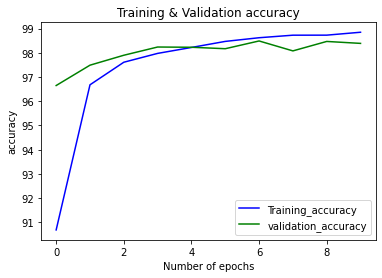

In [89]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop(model, criterion, optimizer, train_loader, valid_loader)
plot_result(total_train_loss, total_valid_loss, 'loss')
plot_result(total_train_accuracy, total_valid_accuracy, 'accuracy')
